### Approximating the Lorenz attractor with Nonlinear Vector Autoregression (NVAR)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scipy.optimize
import sys
import warnings
from IPython.display import clear_output, display
import sympy as sp
import copy

# from NVAR import *
# from utils import RMSE
from cmlCore import *
from cmlUtils import *

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
T = 300
dt = 0.01

lorenz = np.loadtxt(f'./datasets/py-lorenz_RK4_T={T}_dt={dt}.csv', delimiter=",", dtype='float64')

# c = 1/50
# feature_mean = lorenz[:,1:].mean(axis=0)
# target_mean = lorenz[1:,1:].mean(axis=0)

raw_data = lorenz[:,1:]
raw_target = lorenz[1:,1:]

data = raw_data
target = raw_target

# data = np.tanh((lorenz[:,1:]-feature_mean)*c)
# target = np.tanh((lorenz[1:,1:]-target_mean)*c)

k=4
# k=8
# k=12
# k=16

train_start=16500
train_end=24000
test_start=train_end
test_end=26000

training_target = target[train_start:train_end]
test_target = target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

train_indices.shape, test_indices.shape

((7500,), (2000,))

In [3]:
testRecursiveNVARParams(
    k=k,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    linearFunc=pureLinearFunc,
    nonlinearFunc=quadraticCombination,
    extranonlinearFunc=None
)

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params:
k  :4
s  :5
reg:1e-07


In [4]:
quadratic_model_100 = NVARModel(k=4, s=5, reg=1e-7, nonlinearFunc=quadraticCombination) # k=4 -> 91 "units"
# quadratic_model_100 = NVARModel(k=8, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=8 -> 325 "units"
# quadratic_model_100 = NVARModel(k=12, s=4, reg=1e-6, nonlinearFunc=quadraticCombination) # k=12 -> 703 "units"
# quadratic_model_100 = NVARModel(k=16, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=16 -> "1225 units"
quadratic_model_100.train(data, target, train_indices)
quadratic_model_100.evaluate(data, target, test_indices)
print(f'test RMSE: {quadratic_model_100.test_RMSE}')

test RMSE: 8.444987171792031e-06


recursive RMSE: 7.571250854123598
recursive NRMSE: 0.1894906193524041


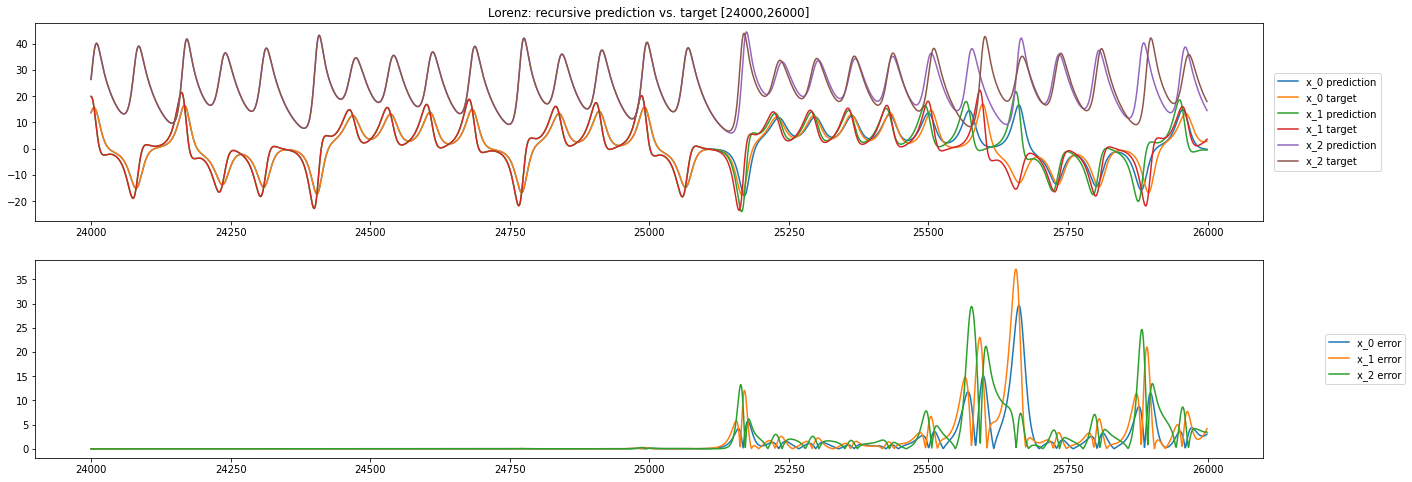

In [5]:
t_forward = 2000
recursive_out = quadratic_model_100.recursive_predict(data, train_start, train_end, t_forward)
print(f'recursive RMSE: {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
print(f'recursive NRMSE: {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(recursive_out, data, train_end, t_forward)

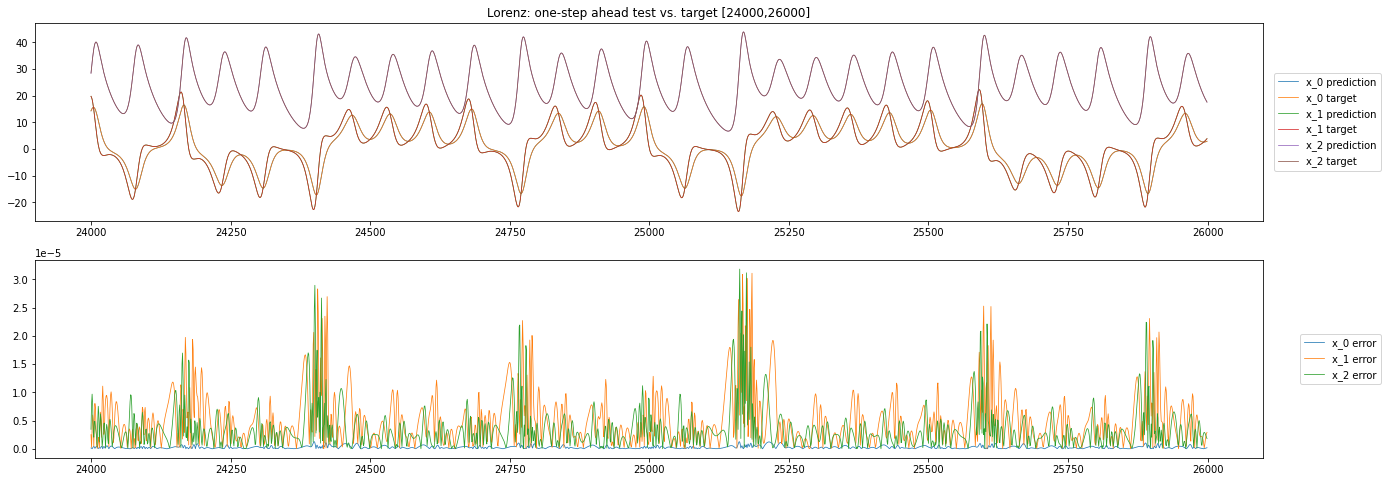

In [6]:
plotTestComparison(quadratic_model_100.test_out, target, train_end, 2000)

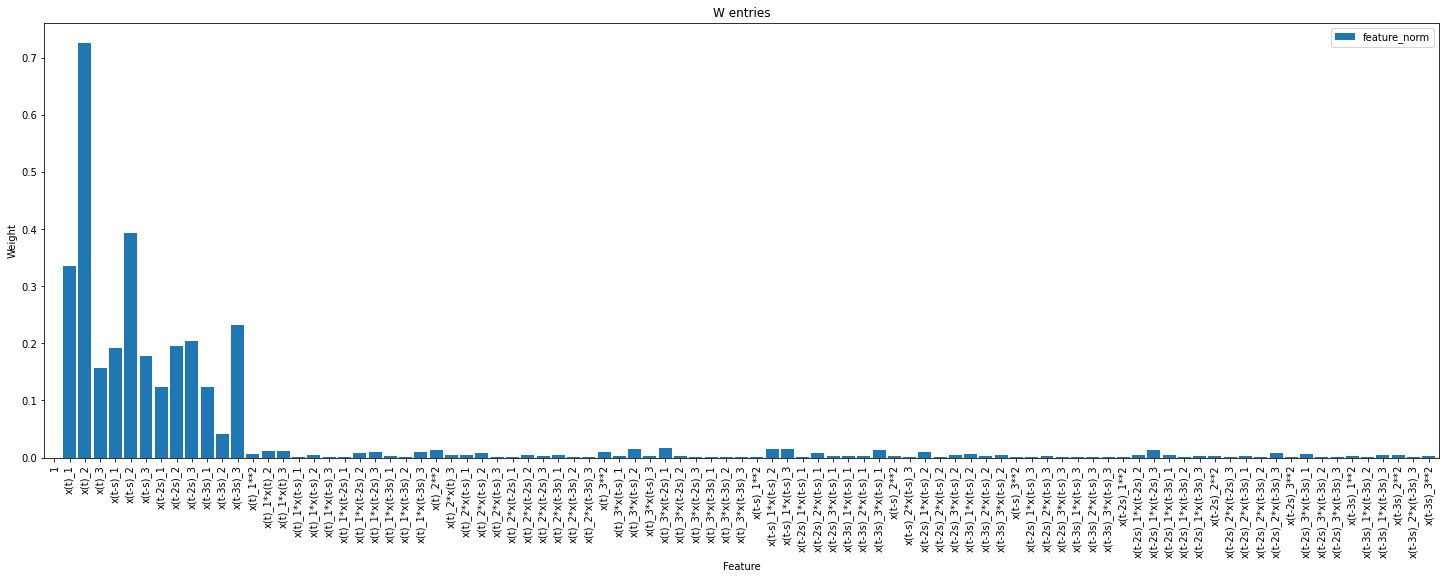

In [7]:
symb_state = get_symbolic_state_labels(
    k=4,
    d=3,
    nonlinearFunc = quadraticCombination,
    extraNonlinearFunc = None
)

df_100 = makeCombinedWeightDF(quadratic_model_100.w, symb_state)
plotWeights(df_100)

Same dataset, but 2x larger training window

In [8]:
k=4
# k=8
# k=12
# k=16

train_start=9000
train_end=24000
test_start=train_end
test_end=26000

training_target = target[train_start:train_end]
test_target = target[test_start:]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

train_indices.shape, test_indices.shape

((15000,), (2000,))

In [9]:
testRecursiveNVARParams(
    k=k,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    linearFunc=pureLinearFunc,
    nonlinearFunc=quadraticCombination,
    extranonlinearFunc=None
)

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params:
k  :4
s  :2
reg:1e-06


In [10]:
quadratic_model_300 = NVARModel(k=4, s=2, reg=1e-6, nonlinearFunc=quadraticCombination) # k=4
# quadratic_model_300 = NVARModel(k=8, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=8 TBC
# quadratic_model_300 = NVARModel(k=12, s=4, reg=1e-6, nonlinearFunc=quadraticCombination) # k=12 TBC
# quadratic_model_300 = NVARModel(k=16, s=2, reg=0.001, nonlinearFunc=quadraticCombination) # k=16 TBC
quadratic_model_300.train(data, target, train_indices)
quadratic_model_300.evaluate(data, target, test_indices)
print(f'test RMSE: {quadratic_model_300.test_RMSE}')

test RMSE: 5.16722280561166e-06


recursive RMSE: 1.4260049269741768
recursive NRMSE: 0.035689552759270576


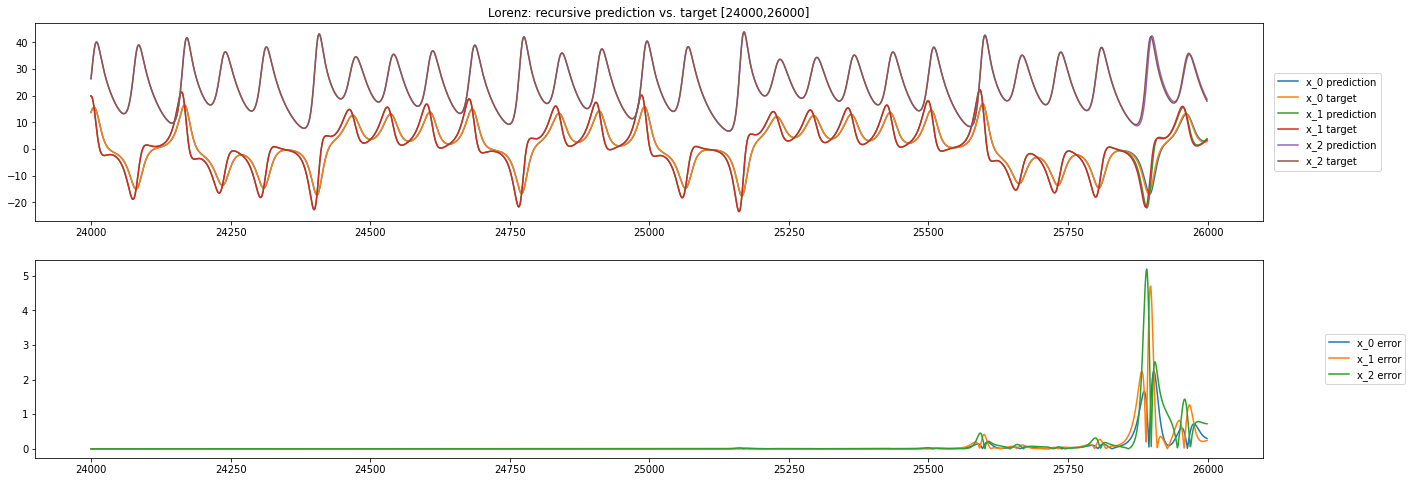

In [11]:
t_forward = 2000
recursive_out = quadratic_model_300.recursive_predict(data, train_start, train_end, t_forward)
print(f'recursive RMSE: {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
print(f'recursive NRMSE: {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(recursive_out, data, train_end, t_forward)

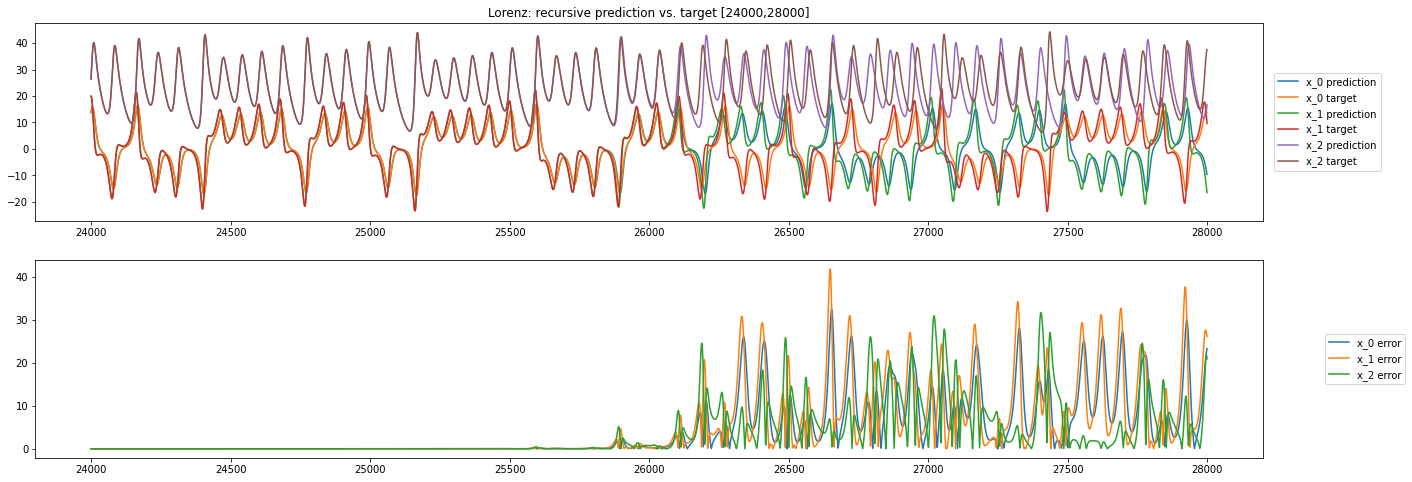

In [12]:
recursive_out = quadratic_model_300.recursive_predict(data, train_start, train_end, 4000)
plotRecursiveComparison(recursive_out, data, train_end, 4000)

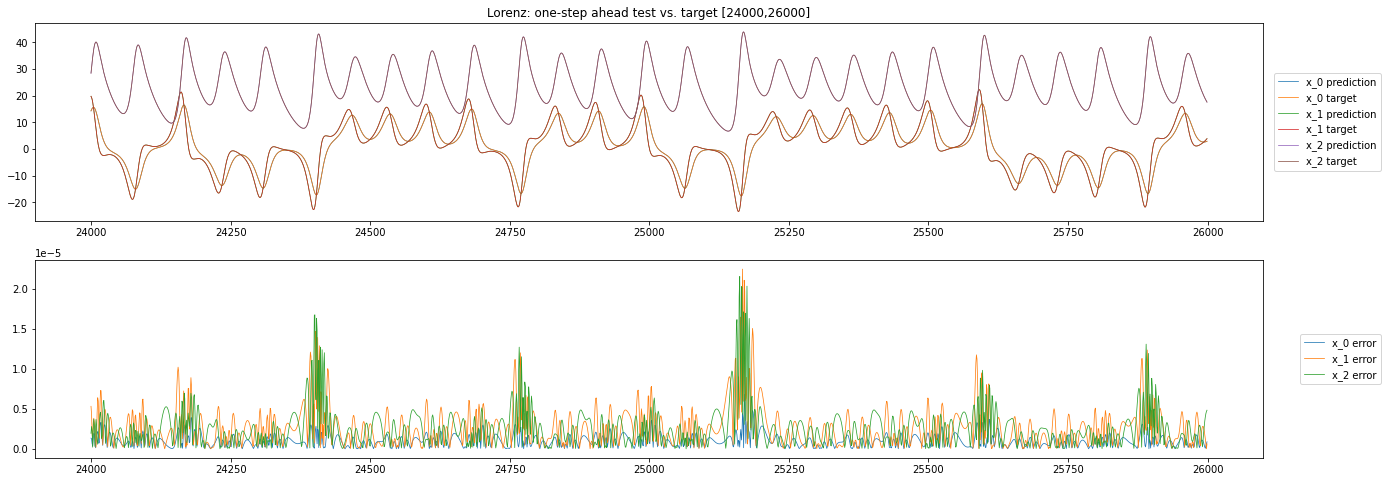

In [13]:
plotTestComparison(quadratic_model_300.test_out, target, train_end, 2000)

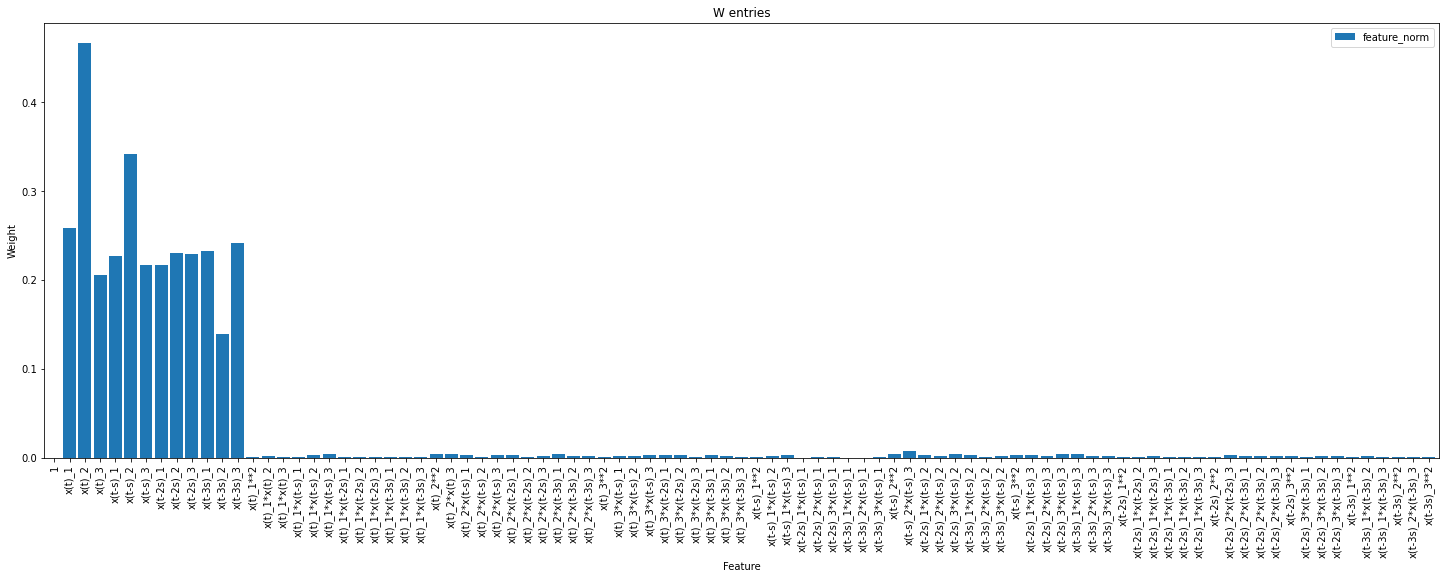

In [14]:
df_300 = makeCombinedWeightDF(quadratic_model_300.w, symb_state)
plotWeights(df_300)

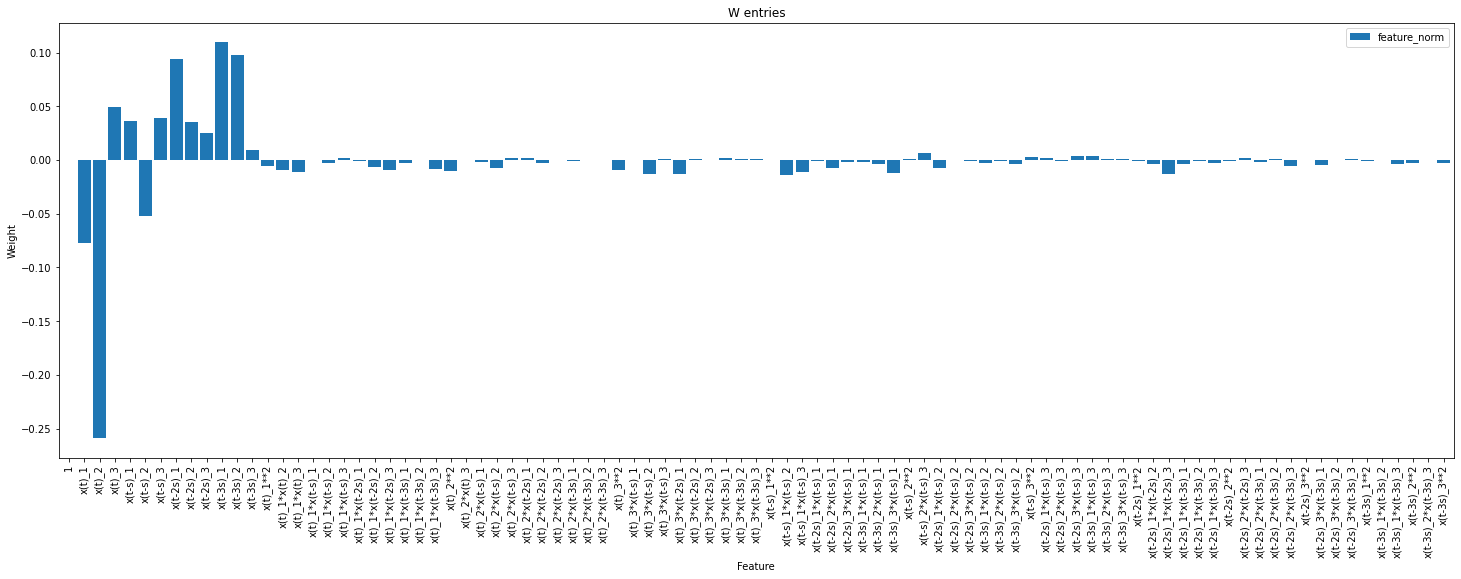

In [15]:
df_diff = df_300.copy(deep=True)
df_diff['feature_norm'] = df_diff['feature_norm'] - df_100['feature_norm']

plotWeights(df_diff)

Extra-nonlinear model (added $\tanh$) on large dataset

In [16]:
testRecursiveNVARParams(
    k=k,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    linearFunc=pureLinearFunc,
    nonlinearFunc=quadraticCombination,
    extranonlinearFunc=np.tanh
)

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params:
k  :4
s  :2
reg:0.001


In [17]:
extra_nl_model_300 = NVARModel(k=4, s=2, reg=0.001, nonlinearFunc=quadraticCombination, extraNonlinearFunc=np.tanh)
extra_nl_model_300.train(data, target, train_indices)
extra_nl_model_300.evaluate(data, target, test_indices)
print(f'test RMSE: {extra_nl_model_300.test_RMSE}')

test RMSE: 4.956335853077572e-06


recursive RMSE: 8.288234653483736
recursive NRMSE: 0.20743503921433443


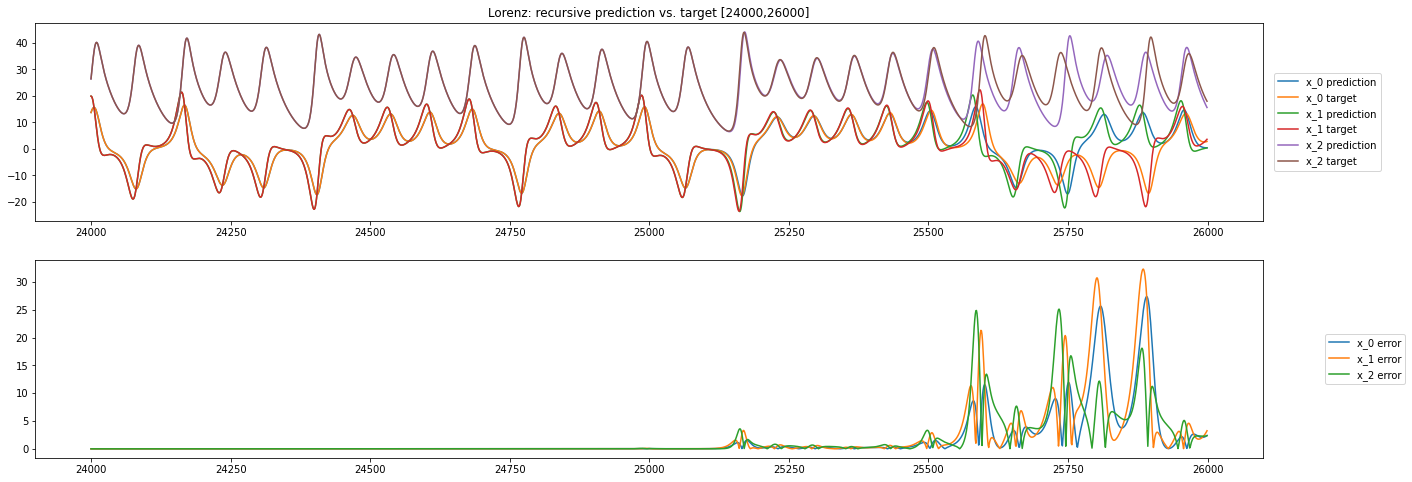

In [18]:
t_forward = 2000
recursive_out = extra_nl_model_300.recursive_predict(data, train_start, train_end, t_forward)
print(f'recursive RMSE: {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
print(f'recursive NRMSE: {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(recursive_out, data, train_end, t_forward)

recursive RMSE: 15.384958375207322
recursive NRMSE: 0.3775576546588518


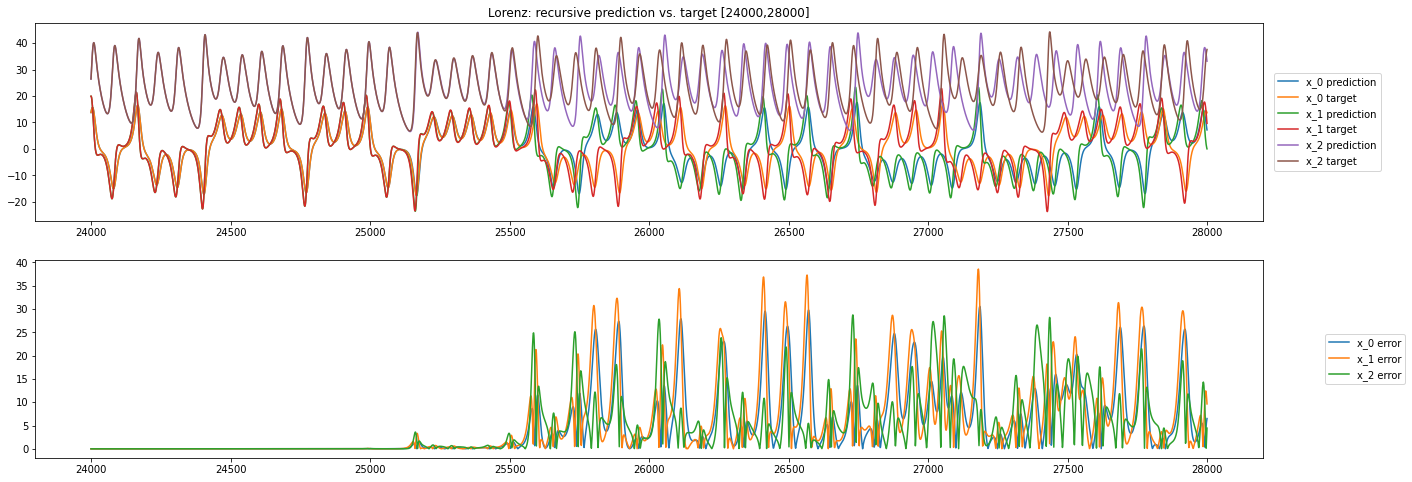

In [30]:
t_forward = 4000
recursive_out = extra_nl_model_300.recursive_predict(data, train_start, train_end, t_forward)
print(f'recursive RMSE: {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
print(f'recursive NRMSE: {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(recursive_out, data, train_end, t_forward)

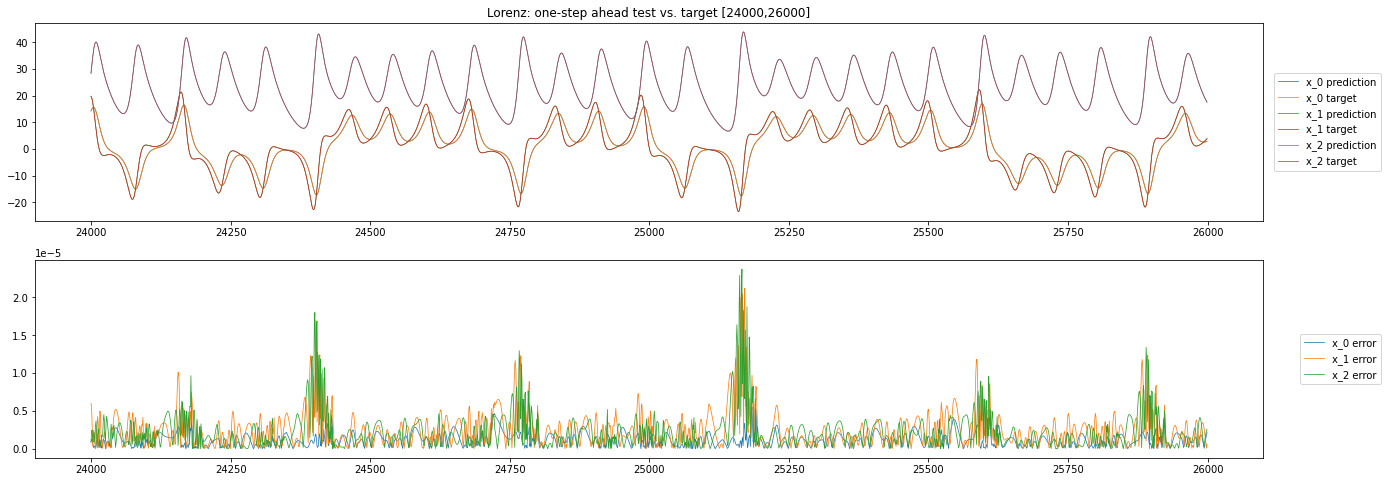

In [44]:
plotTestComparison(extra_nl_model_300.test_out, target, train_end, 2000)

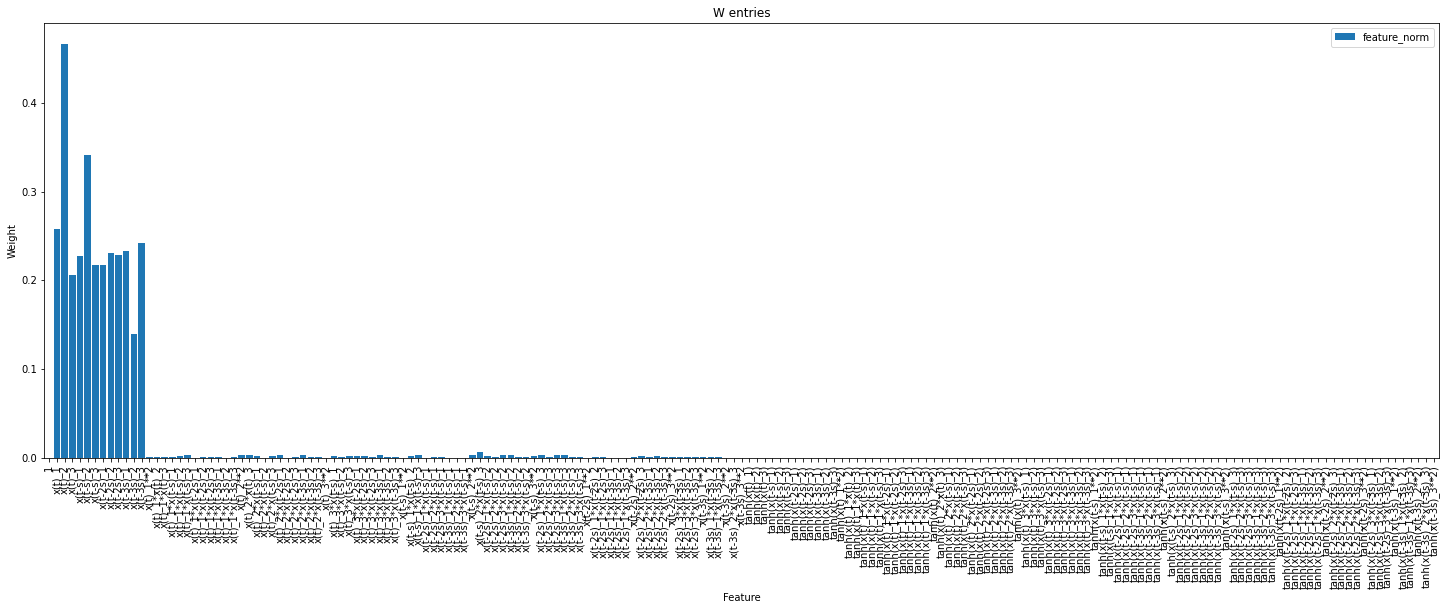

In [33]:
extra_nl_symb_state = get_symbolic_state_labels(
    k=4,
    d=3,
    nonlinearFunc = quadraticCombination,
    extraNonlinearFunc = lambda x: np.array([[sp.tanh(y[0])] for y in x])
)

df_extra_nl_300 = makeCombinedWeightDF(extra_nl_model_300.w, extra_nl_symb_state)
plotWeights(df_extra_nl_300)

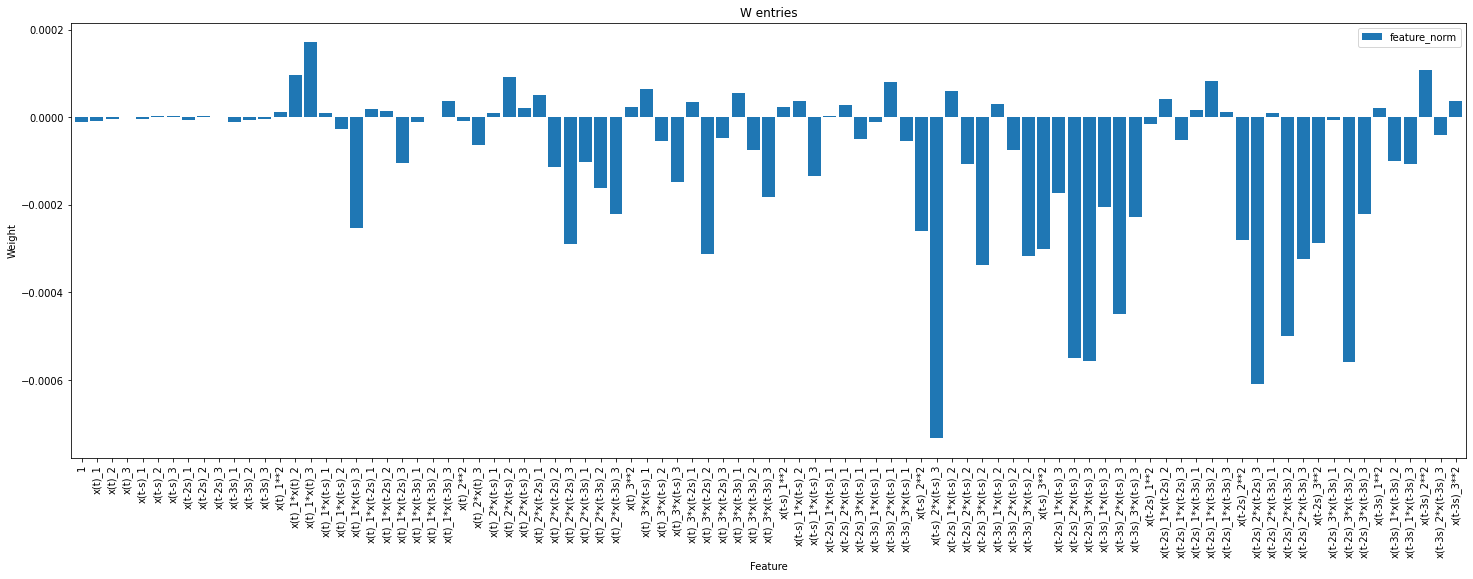

In [35]:
df_diff_300 = df_extra_nl_300.copy(deep=True)
df_diff_300['feature_norm'] = df_diff_300['feature_norm'] - df_300['feature_norm']

plotWeights(df_diff_300[df_diff_300['feature_type']!='extra-nonlinear'])

Linear model on large dataset

In [36]:
testRecursiveNVARParams(
    k=30,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    linearFunc=pureLinearFunc,
    nonlinearFunc=None,
    extranonlinearFunc=None
)

done: scen 55/55 (100.00%) |  s=10 r=0.1
best recursive params:
k  :30
s  :10
reg:1e-07


In [37]:
linear_model_300 = NVARModel(k=30, s=10, reg=1e-7, nonlinearFunc=None, extraNonlinearFunc=None) # k=30 -> 91 model size
linear_model_300.train(data, target, train_indices)
linear_model_300.evaluate(data, target, test_indices)
print(f'test RMSE: {linear_model_300.test_RMSE}')

test RMSE: 0.33312328958366927


recursive RMSE: 14.64324708392902
recursive NRMSE: 0.36648606851439275


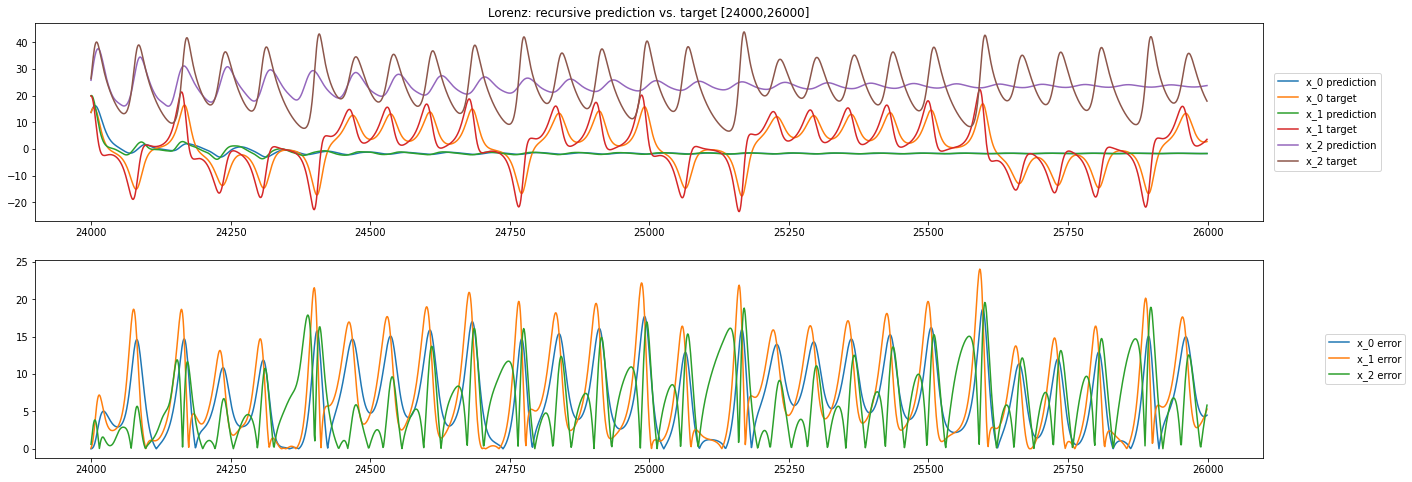

In [39]:
t_forward = 2000
recursive_out = linear_model_300.recursive_predict(data, train_start, train_end, t_forward)
print(f'recursive RMSE: {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
print(f'recursive NRMSE: {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(recursive_out, data, train_end, t_forward)

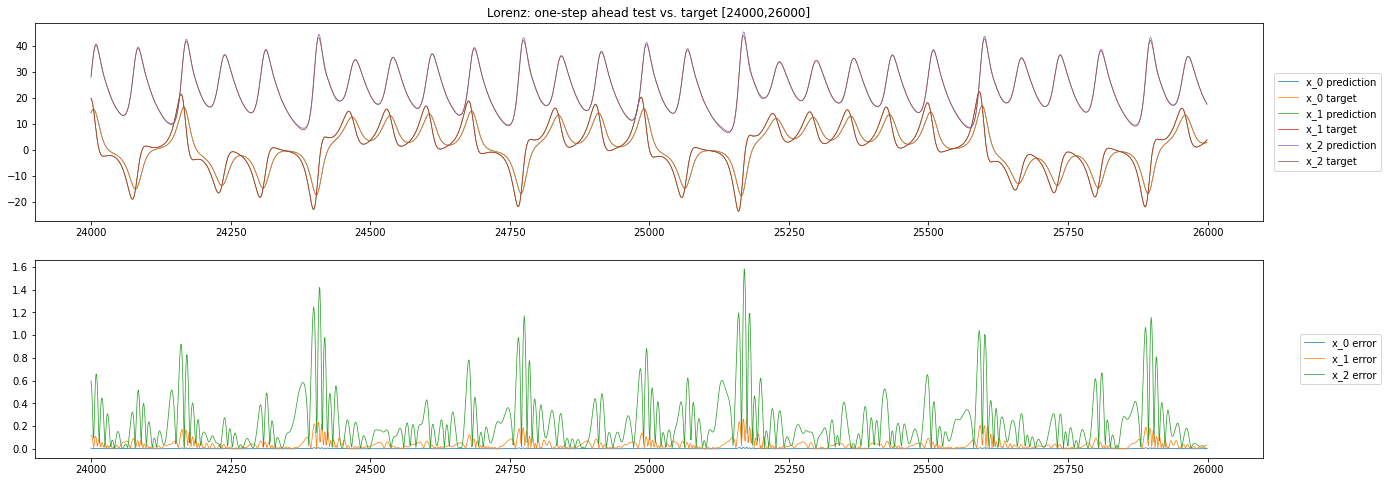

In [46]:
plotTestComparison(linear_model_300.test_out, target, train_end, 2000)

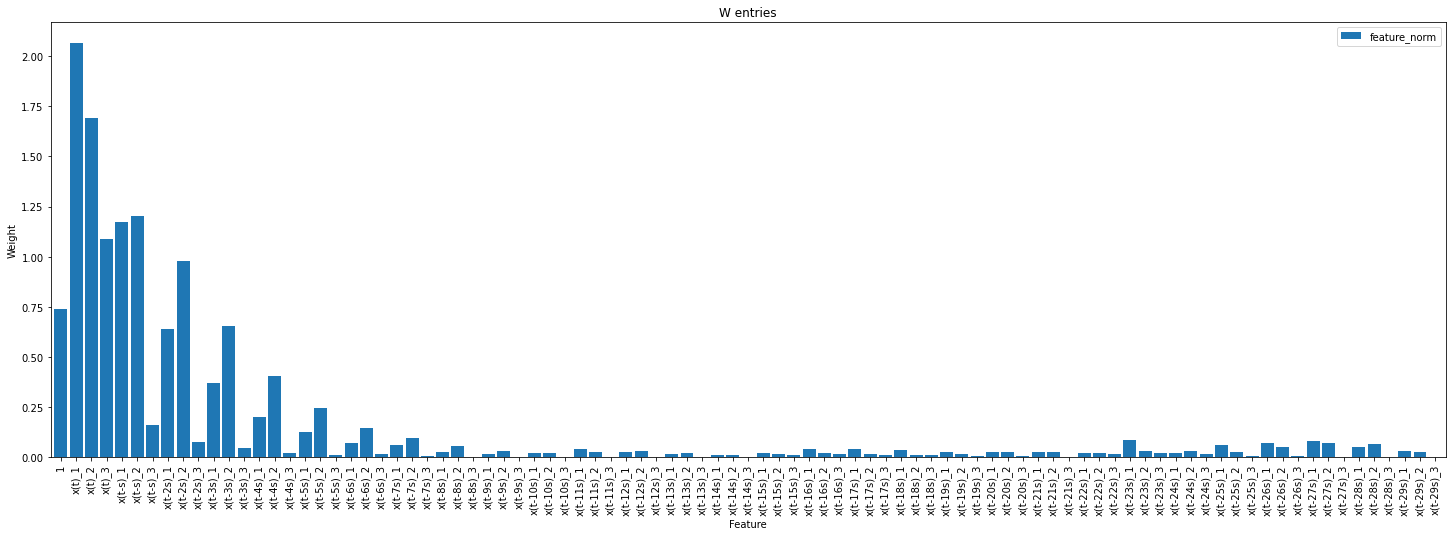

In [41]:
linear_symb_state = get_symbolic_state_labels(
    k=30,
    d=3,
    nonlinearFunc = None,
    extraNonlinearFunc = None
)

df_linear_300 = makeCombinedWeightDF(linear_model_300.w, linear_symb_state)
plotWeights(df_linear_300)

In [49]:
ndf_quad_100 = get_norm_df(symb_state, quadratic_model_100)
ndf_quad_300 = get_norm_df(symb_state, quadratic_model_300)
ndf_extra_nl_300 = get_norm_df(extra_nl_symb_state, extra_nl_model_300)
ndf_linear_300 = get_norm_df(linear_symb_state, linear_model_300)

In [50]:
ndf_comb = pd.concat([ndf_quad_100['total'], ndf_quad_300['total'], ndf_extra_nl_300['total'], ndf_linear_300['total']], axis=1)
ndf_comb = ndf_comb.set_axis(['quadratic_100', 'quadratic_300', 'extra-nonlinear_300', 'linear_300'], axis=1)
ndf_comb.reindex(['bias','linear','nonlinear','extra-nonlinear','total'])

,quadratic_100,quadratic_300,extra-nonlinear_300,linear_300
bias,1.044669e-09,3.844636e-10,9.513129e-11,0.547106
linear,1.051708e+00,8.264803e-01,8.264636e-01,13.490854
nonlinear,2.823684e-03,3.522549e-04,3.077668e-04,NaN
extra-nonlinear,NaN,NaN,1.011120e-07,NaN
total,1.054532e+00,8.268325e-01,8.267715e-01,14.037960


Hybrid NVAR

Work in progress...